In [34]:
from jax import (
    Array, 
    numpy as jnp, 
    lax
)
import flax
import flax.linen as nn

In [29]:
class PositionalEmbedding:
    def __init__(self, max_len: int, d_model: int):
        p, i = jnp.meshgrid(jnp.arange(float(max_len)),jnp.arange(d_model/2) * 2)
        #each shape of (d_model / 2, max_len)
        theta = (p/1e4**(i/d_model)).T  #(d_model/2, max_len)
        self.pos_emb = jnp.stack([
            jnp.sin(theta), jnp.cos(theta)], axis = -1
        ) #shape (max_len, d_model/2, 2)
        self.pos_emb = self.pos_emb.reshape((max_len, d_model))[None] #(1, max_len, d_model)
    def sin_cos_embs(self):
        return self.pos_emb #(1, max_len, d_model)
    
    def compute_freqs(self):
        sin_freqs = jnp.repeat(self.pos_emb
            [..., None, ::2], repeats = 2, axis=-1
        ) # (1, max_len, 1, d_model)
        cos_freqs = jnp.repeat(self.pos_emb
            [..., None, 1::2], repeats = 2, axis=-1  
                            )
        return sin_freqs, cos_freqs

In [74]:
#run pos embeddings
pe = PositionalEmbedding(32, 8)
sin, cos = pe.compute_freqs()
print(sin.shape)

(1, 32, 8)
(1, 32, 1, 8)


Text(0.5, 1.0, 'reference')

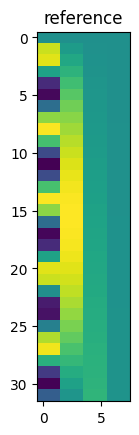

In [44]:
#plot sin frequencies heatmap
import matplotlib.pyplot as plt
plt.imshow(sin[0, :, 0, :])
plt.title("reference")

In [86]:
@nn.nowrap
def precompute_sin_cos_exp_caches(max_len, d_model):
    #position inddices, [0.... seq_len -1]
    position = jnp.arange(0, max_len, dtype=jnp.float32)[:, None]
    #10000 ^ (-2(i-1) / d_model) for i from 1 to d_model/2
    denominator = 1. / jnp.power(
            10000.0 ,
            jnp.arange(0, d_model, 2) / d_model
        )
    #product of position and denominator
    idx_pos_denom = position * denominator
    #directly concatenate so that there is row of pos_denom_product for sin and cos individually
    idx_concat = jnp.concat([idx_pos_denom, idx_pos_denom], axis=-1)

    assert idx_concat.shape == (max_len, d_model)
    #expand middle two dimensions
    cos_cache = jnp.cos(idx_concat)
    sin_cache = jnp.sin(idx_concat)
    return sin_cache, cos_cache

Text(0.5, 1.0, 'mine')

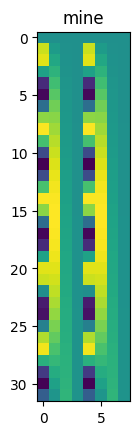

In [123]:
sin, cos = precompute_sin_cos_exp_caches(32, 8)
plt.imshow(sin)
plt.title("mine")

In [121]:
#make arbitrary query and key [batch_size, num_Heads, max_len, head_dim]
# 2 heads...
#dim = heads * head_dim
query = jnp.ones((3, 32, 4, 8))
key = jnp.ones((3, 32, 4, 8))

In [89]:
def rope_emb( key, query, sin_cache, cos_cache, expand_dim = 1):
    #shape: [num_heads, 1, head_dim], so first and third dimension should match key and query dimensions to broadcast
    cos_cache = jnp.expand_dims(cos_cache, axis = expand_dim)
    sin_cache = jnp.expand_dims(sin_cache, axis = expand_dim)
    assert (sin_cache.shape == cos_cache.shape)
    #split query and k into two partsn and rotate, with rotational negation of second half
    query1, query2 = jnp.split(query, 2, axis = -1)
    #[batch_size, num_heads, seq_len, head_dim]
    query_rotated = jnp.concatenate([-query2, query1], axis = -1)
    key1, key2 = jnp.split(key, 2, axis = -1)
    key_rotated = jnp.concatenate([-key2, key1], axis = -1)
    #apply embs to query and key splits
    query_emb = (query * cos_cache) + (query_rotated * sin_cache)
    key_emb = (key * cos_cache) + (key_rotated* sin_cache)
    return query_emb, key_emb

In [96]:
sin_ref, cos_ref = pe.compute_freqs()
#compress dims 0 and 2
sin_ref = sin_ref.squeeze()
cos_ref = cos_ref.squeeze()

In [98]:
#put that into rope emb
q_diff_freq, k_diff_freq = rope_emb(key, query, sin_ref, cos_ref)

Text(0.5, 1.0, 'ref freqs with my rope')

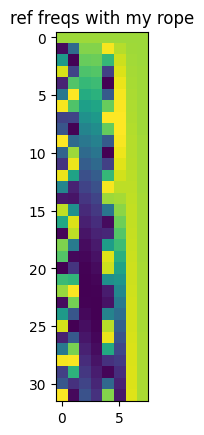

In [103]:
plt.imshow(q_diff_freq[0, :, 0, :])
plt.title("ref freqs with my rope")

In [124]:
query, key = rope_emb(key, query, sin, cos)

In [125]:
query.shape

(3, 32, 4, 8)

Text(0.5, 1.0, 'mine')

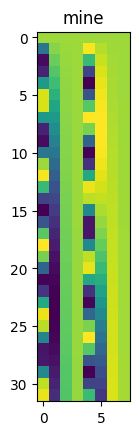

In [102]:
#visualize for one head
plt.imshow(query[0, :, 0, :])
plt.title("mine")

In [80]:
def apply_rotary_embeddings(q:Array, k:Array, sin_freqs:Array, cos_freqs:Array):
    T = q.shape[1]
    minus_swap_alternate = lambda x: jnp.stack([-x[..., 1::2], x[..., ::2]], axis=-1).reshape(x.shape)
    print(minus_swap_alternate(q).shape)
    print(cos_freqs[:, :T, :, :].shape)
    q = q*cos_freqs[:, :T, :, :] + minus_swap_alternate(q)*sin_freqs[:, :T, :, :] # (B, T, h, dq)*(1, T, 1, dq) + (B, T, h, dq)*(1, T, 1, dq)
    k = k*cos_freqs[:, :T, :, :] + minus_swap_alternate(k)*sin_freqs[:, :T, :, :] # (B, T, h, dq)*(1, T, 1, dq) + (B, T, h, dq)*(1, T, 1, dq)
    return q, k # (B, T, h, dq), (B, T, h, dq)

In [130]:
q, k = jnp.ones((3, 32, 4, 8)), jnp.ones((3, 32, 4, 8))
pe = PositionalEmbedding(32, 8)
sin, cos = pe.compute_freqs()

(1, 32, 8)


In [131]:
q, k = apply_rotary_embeddings(q, k, sin, cos)

(3, 32, 4, 8)
(1, 32, 1, 8)


Text(0.5, 1.0, 'reference')

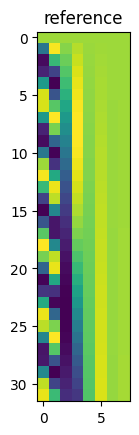

In [100]:
#visualize rotary embeddings
plt.imshow(q[0, :, 0, :])
plt.title("reference")

Trying out new RoPE Embs instead:

In [1]:
from mla_enc_only import *

/kuhpc/work/slusky/syasna_sta/.conda/envs/flax/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [138]:
#multi head latent attention
class MLA(nn.Module):
    num_heads: int
    embed_dim: int
    
    def setup(self):
        self.head_dim = self.embed_dim // self.num_heads #since should naturally project below onto oringal embed_dim
        self.query_proj = nn.Dense(
            self.num_heads * self.head_dim,
            kernel_init = nn.initializers.xavier_uniform()
        )
        self.key_proj = nn.Dense(
            #normally would project ot a reduced number of key-value heads..
            self.num_heads * self.head_dim,
            kernel_init = nn.initializers.xavier_uniform()
        )
        self.value_proj = nn.Dense(
            self.num_heads * self.head_dim,
            kernel_init=nn.initializers.xavier_uniform()
        )
    
        #final output projection of attention
        self.o_proj = nn.Dense(
            self.embed_dim,
            kernel_init = nn.initializers.xavier_uniform()
        )
    def __call__(self, x,
                sin, #position embeddings...
                cos, 
                mask=None):
        #get these for scaling reshapes below
        batch_size, seq_length, embed_dim = x.shape

        if mask is not None: 
            #mask min 3 dims
            mask = expand_mask(mask) 
            
        #up projection
        #shape [batch_size, seq_length, num_heads*head_dim]
        query_state = self.query_proj(x)
        key_state = self.key_proj(x)
        value_state = self.value_proj(x)
        
        #[batch_size, seq_length, num_heads*head_dim] ->
        #[batch_size, seq_length, num_heads, head_dim] ->
        #[batch_size, num_heads, seq_length, head_dim]
        query_state = query_state.reshape(
            batch_size, seq_length, self.num_heads, -1
        ).transpose(0, 2, 1, 3)
        key_state = key_state.reshape(
            batch_size, seq_length, self.num_heads, -1
        ).transpose(0, 2, 1, 3)
        value_state = value_state.reshape(
            batch_size, seq_length, self.num_heads, -1
        ).transpose(0, 2, 1, 3)
        print("sin shape",sin.shape)
        #applied rope embeddings (shape maintained)
        query_state, key_state = apply_rotary_embeddings(query_state, 
                                        key_state, 
                                        sin, 
                                        cos)
        
        #scaled dot product attention with mask
        values, attention = scaled_dot_product(key_state, query_state, value_state, mask)
        
        #softmax to get attention probabilities [batch_size, num_heads, seq_length, head_dim / 2]
        attention_weights = nn.softmax(attention, axis = -1)
        #dot product of weights with values
        attn_output = jnp.matmul(attention_weights, values)
        #reshape output, compress last two dimensions for each head
        #-> [batch_size, num_heads, embed_dim]
        attn_output = attn_output.transpose(0, 2, 1, 3)
        attn_output = attn_output.reshape(batch_size, seq_length, embed_dim)
        #attn_output proj back to original shape of x: [batch_size, seq_length, embed_dim]
        #attention_weights maintains k q v state shapes: [batch_size, num_heads, seq_length, head_dim ]
        return self.o_proj(attn_output), attention_weights

In [2]:
model_dim = 32
num_heads = 4
pe = PositionalEmbedding(num_heads, model_dim // num_heads)
sin, cos = pe.compute_freqs()

In [6]:
print(cos.shape)
T = 2
cos[:, :T, :, :]

(1, 4, 1, 8)


Array([[[[1.       , 1.       , 1.       , 1.       , 1.       ,
          1.       , 1.       , 1.       ]],

        [[0.5403023, 0.5403023, 0.9950042, 0.9950042, 0.99995  ,
          0.99995  , 0.9999995, 0.9999995]]]], dtype=float32)

In [140]:
#encoder-only full model with multi-head latent attention
class MLATransformer(nn.Module): 
    model_dim : int
    num_heads : int
    num_classes : int
    num_layers : int
    dropout_rate : float = 0.0
    init_dropout_rate : float = 0.0
    
    def setup(self):
        #dropout and output model_dim size
        self.input_dropout = nn.Dropout(rate = self.init_dropout_rate)
        self.input_layer = nn.Dense(self.model_dim)

        self.enc = MLATransformerEncoder(
            num_layers = self.num_layers,
            input_dim = self.model_dim,
            num_heads = self.num_heads,
            dim_feedforward = 2 * self.model_dim,
            dropout_rate = self.dropout_rate
        )
        
        #mlp output (no decoder for now)
        self.out = [
            nn.Dense(self.model_dim),
            nn.LayerNorm(),
            nn.relu,
            nn.Dropout(rate = self.dropout_rate),
            nn.Dense(self.num_classes)
        ]
    
    def __call__(self, 
            x,
            sin, 
            cos,
            mask=None,
            train = True
            ):
        x = self.input_dropout(x, deterministic = not train)
        x = self.input_layer(x)
        x = self.enc(x, sin, cos, mask, deterministic = not train)
        for l in self.out:
            x = l(x, deterministic = not train) if isinstance(l, nn.Dropout) else l(x)
        return x

In [3]:
main_rng, x_rng = jax.random.split(jax.random.PRNGKey(0))
x = random.normal(x_rng, (3, 32, 32))
mask = jax.random.bernoulli(main_rng, p=0.5, shape=(3, 16, 64))

transpre = MLATransformer(num_layers=5,
                                model_dim=model_dim,
                                num_classes=10,
                                num_heads=num_heads,
                                dropout_rate=0.15,
                                init_dropout_rate=0.05)

In [ ]:
main_rng, init_rng, dropout_init_rng = random.split(main_rng, 3)
params = transpre.init({'params': init_rng, 
                    'dropout': dropout_init_rng}, 
                    x= x, 
                    cos = cos,
                    sin = sin, train= True)['params']

main_rng, dropout_apply_rng = random.split(main_rng)
# Instead of passing params and rngs every time to a function call, we can bind them to the module
binded_mod = transpre.apply({'params': params}, x= x, 
                            sin=sin, 
                            cos = cos,
                            rngs={'dropout': dropout_apply_rng})
print(binded_mod.shape)

Reverse dataest test with RoPE reference

In [1]:
DATASET_PATH = "/kuhpc/work/slusky/syasna_sta/env_setup_test/data"

In [2]:
from rev_task import *
from mla_enc_only import *
from rev_task import ReverseTrainer

/kuhpc/work/slusky/syasna_sta/.conda/envs/flax/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dataset = partial(ReverseDataset, 10, 16)
rev_train_loader = data.DataLoader(dataset(50000, np_rng=np.random.default_rng(42)),
                                   batch_size=128,
                                   shuffle=True,
                                   drop_last=True,
                                   collate_fn=numpy_collate)
rev_val_loader   = data.DataLoader(dataset(1000, np_rng=np.random.default_rng(43)),
                                   batch_size=128,
                                   collate_fn=numpy_collate)
rev_test_loader  = data.DataLoader(dataset(1000, np_rng=np.random.default_rng(44)),
                                   batch_size=128,
                                   collate_fn=numpy_collate)

In [4]:
def train_reverse(max_epochs = 10, **model_args):
    num_train_iters = len(rev_train_loader) * max_epochs
    trainer = ReverseTrainer('MLA-Reverse', 
                            exmp_batch = next(iter(rev_train_loader)),
                            max_iters = num_train_iters,
                            **model_args
    )
    if not trainer.checkpoint_exists():
        trainer.train_model(rev_train_loader, rev_val_loader, num_epochs=max_epochs)
        trainer.save_model()
        
    else:
        trainer.load_model(pretrained=True)

    val_acc = trainer.eval_model(rev_val_loader)
    test_acc = trainer.eval_model(rev_test_loader)
    #bind, inference so no dropout rng 
    trainer.model_bd = trainer.model.bind({'params': trainer.state.params})
    return trainer, {'val_acc': val_acc, 'test_acc': test_acc}

In [7]:
model_dim = 32
num_heads = 2
pe = PositionalEmbedding(num_heads, model_dim // num_heads)
sin, cos = pe.compute_freqs()
reverse_trainer, reverse_result = train_reverse(model_dim=32,
                                                num_heads=2,
                                                num_classes=rev_train_loader.dataset.num_categories,
                                                num_layers=3,
                                                sin = sin,
                                                cos = cos,
                                                init_dropout_rate=0.0,
                                                dropout_rate = 0.1,
                                                lr=5e-4,
                                                warmup=50)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [02:03<00:00, 12.36s/it]


In [8]:
print(f"Val accuracy:  {(100.0 * reverse_result['val_acc']):4.2f}%")
print(f"Test accuracy: {(100.0 * reverse_result['test_acc']):4.2f}%")

Val accuracy:  23.61%
Test accuracy: 24.19%
